In [1]:
%load_ext Cython

In [2]:
import numpy as np

In [3]:
# create some random data:
# we want radial data to be of length 
r_len = 1000
# and we want 
z_len = 300
# different independend slices in z direction.

dtype = np.float
T = np.random.rand(r_len * z_len).astype(dtype).reshape(z_len, r_len)

In [4]:
triangle = np.zeros.rand(r_len * z_len).astype(dtype).reshape(z_len, r_len)


AttributeError: 'builtin_function_or_method' object has no attribute 'rand'

In [ ]:
# definie output

#      z
#  |------| 
#  |------| y
#  |------|
#

output = np.zeros(r_len * z_len, dtype=dtype).reshape(r_len, z_len)

In [ ]:
# start with numpy and python
for yy in range(r_len):
    r_vec = np.arange( yy, r_len , 1) + 0.5
    # + 0.5 intervall middle (dr)
    # construct K_y
    r_vec = r_vec**2
    r_vec = r_vec - (yy)**2
    r_vec = np.sqrt(r_vec)
    # matrix * vector 
    out = np.dot(T[:, yy:],r_vec)
    output[yy,:] = out 

In [ ]:
output

In [ ]:
def rotation_np(input_data):
    z_len, r_len = input_data.shape
    # deifine output:
    #
    #      z
    #  |------| 
    #  |------| y
    #  |------|
    #
    output = np.zeros(r_len * z_len, dtype=dtype).reshape(r_len, z_len)
    for yy in range(r_len):
        r_vec = np.arange( yy, r_len , 1) + 0.5
        # + 0.5 intervall middle (dr)
        # construct K_y
        r_vec = r_vec**2
        r_vec = r_vec - (yy)**2
        r_vec = np.sqrt(r_vec)**(-1)
        print(r_vec)
        # matrix * vector 
        out = np.dot(input_data[:, yy:],r_vec)
        output[yy,:] = out 
    return output

In [5]:
rotation_np(T)

NameError: name 'rotation_np' is not defined

In [196]:
%%cython -a
cimport cython
cimport numpy as np
import  numpy as np
from libc.math cimport sqrt
from scipy.linalg.cython_blas cimport dgemv
#@cython.boundscheck(False)
#@cython.wraparound(False)

cdef int _rotation(double [:,::1] input_data, double [:,::1] output_data,
                  double [:] coeff):
    cdef Py_ssize_t r_len, s_len
    r_len = input_data.shape[1]
    s_len = input_data.shape[0]
    cdef Py_ssize_t r_len_down, r_len_up, r_start_up, r_start_down, loop_start
    cdef bint input_is_odd 
    if r_len%2 ==0:
        input_is_odd = False
        r_len_down = r_len//2
        r_len_up = r_len_down
        r_start_up = r_len_down 
        r_start_down = 0
        loop_start = 0
    else:
        input_is_odd = True
        #include 0th line (middle) in the down part.
        r_len_down = r_len // 2 + 1 # floor division
        r_len_up = r_len // 2
        r_start_up = r_len_down 
        r_start_down = 0 
        loop_start = 1
    cdef Py_ssize_t yy, ii

    cdef char* trans = 't'
    cdef int n = s_len
    cdef Py_ssize_t  mm
    cdef int m
    cdef int lda = r_len
    cdef double alpha = 1
    cdef double beta = 0
    cdef int incy = 1
    cdef int incx_up = 1
    cdef int incx_down = 1
    cdef double* A_start_up
    cdef double* A_start_down
    cdef double* output_start_up
    cdef double* output_start_down
    cdef double* coeff_start_up = &coeff[0]
    cdef double* coeff_start_down
    cdef double val
    for yy in range(loop_start, r_len_up):
        mm = r_len_up - yy
        coeff_start_down = &coeff[mm]
        for ii in range (mm):   # ii radius steps
            val = yy * (sqrt((yy + ii + 0.5)**2 - yy**2))**(-1)
            coeff[2*mm-1-ii] = val 
            coeff[ii] = val
        #
        m = mm
        A_start_up = &input_data[0,r_start_up + yy]
        A_start_down = &input_data[0,r_start_down]
        output_start_down = &output_data[r_len - r_len_up+ yy,0]
        output_start_up = &output_data[r_len_up -1  - yy,0]
        dgemv(trans, &m, &n, &alpha, A_start_up, &lda, coeff_start_up,
                         &incx_up, &beta, output_start_up, &incy)
        dgemv(trans, &m, &n, &alpha, A_start_down, &lda, coeff_start_down,
                        &incx_down , &beta, output_start_down, &incy)
    if input_is_odd:
        #calculate the middle line
        m = r_len_down
        for ii in range (m):
            coeff[ii] = (sqrt(ii + 0.5)**2)**(-1)
        A_start_down = &input_data[r_len_down,0]
        output_start_down = &input_data[r_len_down,0]

        dgemv(trans, &m, &n, &alpha, A_start_down, &lda, coeff_start_down,
                         &incx_down, &beta, output_start_down, &incy)   
    return 0

def rotation(input_data):
    try:
        input_data.flags
    except AttributeError:
        print('input_data should be a numpy array!')
        raise
    if input_data.flags['F_CONTIGUOUS']:
        print('input_data should be stored in a raw major, C contigous.')
    elif not input_data.flags['C_CONTIGUOUS']:
        print('input_data as to be a contigous array.')
    
    output = np.zeros(input_data.size, dtype=np.float64, order='C').reshape(
                    input_data.shape[1], input_data.shape[0])
    # coeff hast the length of the half of the distribution;
    # +1 for the odd case (odd number of columns).
    coeff = np.empty(input_data.shape[1], dtype=np.float64, order='C')
    
    cdef double [:,::1] input_data_view = input_data
    cdef double [:,::1] output_view = output
    cdef double [:] coeff_view = coeff
    _rotation(input_data_view, output_view, coeff_view)
    return output

In [164]:
np.set_printoptions(threshold=200)

In [165]:
rotation(T) 

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [166]:
rotation_np(T[:,4::-1])[::1,:]

NameError: name 'rotation_np' is not defined

In [ ]:
rotation_np(T[:,5:])

In [94]:
T

array([[0.80653783, 0.60174602, 0.47071121, ..., 0.18914663, 0.23678362,
        0.2776054 ],
       [0.21164463, 0.38900425, 0.51600751, ..., 0.49898522, 0.89570024,
        0.37001438],
       [0.10418721, 0.12021271, 0.86848853, ..., 0.19260882, 0.71524399,
        0.38768183],
       ...,
       [0.57698374, 0.37981449, 0.64613794, ..., 0.75832805, 0.19634609,
        0.71919032],
       [0.53474947, 0.55243575, 0.34321769, ..., 0.29069428, 0.63622328,
        0.99402326],
       [0.41651212, 0.08609759, 0.96732537, ..., 0.87097829, 0.71352625,
        0.50434612]])

In [95]:
T[:,1::-1]

array([[0.60174602, 0.80653783],
       [0.38900425, 0.21164463],
       [0.12021271, 0.10418721],
       ...,
       [0.37981449, 0.57698374],
       [0.55243575, 0.53474947],
       [0.08609759, 0.41651212]])

In [96]:
path = '../../Faraday_Rotation/test_samples/'

In [142]:
file_name = '3'

In [151]:
test_sample = np.load(path + file_name + '.npy')

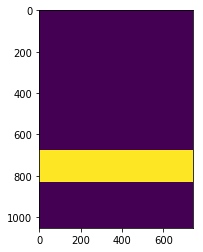

In [152]:
plt.imshow(test_sample)

In [177]:
test_sample.shape[1]/2

372.0

In [199]:
rotated = rotation(np.ascontiguousarray(test_sample[::-1,:]).astype(np.float64))

In [194]:
import matplotlib.pyplot as plt

In [191]:
rotated2 = rotated
rotated2[200:430,:] = 0

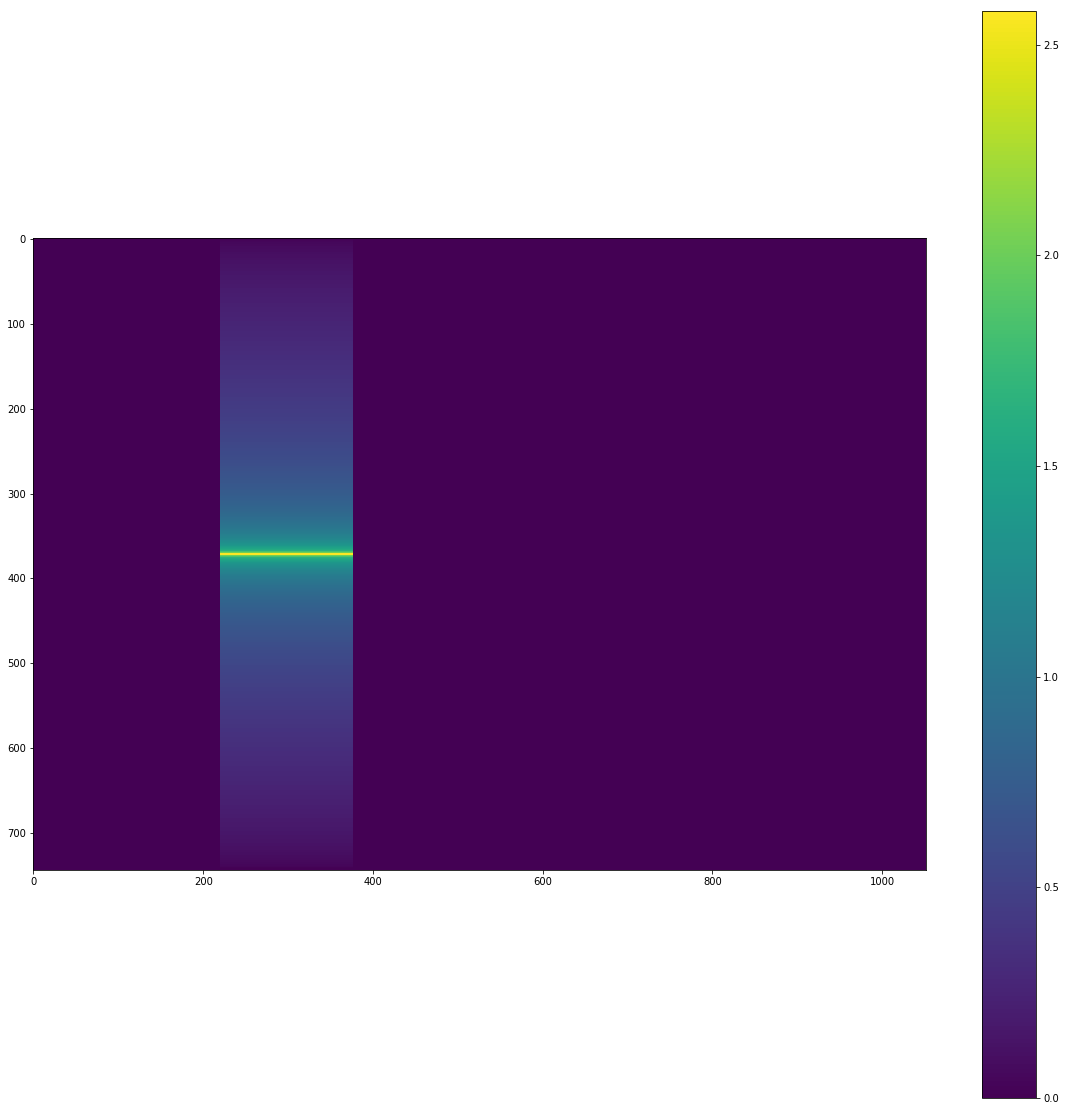

In [198]:
f, ax = plt.subplots(1, figsize=(20,20))
ax.imshow(rotated)
f.colorbar(ax.images[0])
#f.savefig('out3.jpg')